In [27]:

from pathlib import Path
import torchaudio
import torch
import torch.nn.functional as F
import pandas as pd
from speechbrain.pretrained import EncoderClassifier
import itertools
import ast
import json
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained ECAPA model
classifier = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="ecapa_pretrained"
).to(device)

def get_embedding(wav_path):
    """Returns a normalized ECAPA embedding vector [emb_dim]."""
    signal, fs = torchaudio.load(str(wav_path))
    if fs != 16000:
        signal = torchaudio.functional.resample(signal, fs, 16000)
    signal = signal.to(device)

    with torch.no_grad():
        emb = classifier.encode_batch(signal)   # shape [1, 1, emb_dim]

    emb = emb.squeeze(0).squeeze(0)
    emb = F.normalize(emb, p=2, dim=0) # L2 normalization
    return emb.cpu()

print("Model loaded successfully.")


Model loaded successfully.


c:\Users\yoav1\OneDrive\Desktop\לימודים\year4\final\BioVoice\venv\lib\site-packages\speechbrain\utils\checkpoints.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch

In [28]:

# Extract ECAPA embeddings for ALL wav files in data_dir

data_dir = Path("./data")
wav_paths = sorted(list(data_dir.glob("*.wav")))

rows = []
emb_dict = {}  
for wav in wav_paths:
    emb = get_embedding(wav)
    true_label = wav.stem.split("_")[0]   
    
    emb_dict[str(wav)] = emb
    rows.append({
        "path": str(wav),
        "true_label": true_label,
        "embedding_vector": emb.numpy().tolist()  
    })

df_emb = pd.DataFrame(rows)
df_emb.to_csv("users_embeddings.csv", index=False)



# df_emb.head()


In [29]:
# Compute pairwise cosine similarity for embeddings of the SAME speaker
df = df_emb.copy()
# df["embedding_vector"] = df["embedding_vector"].apply(json.loads)
# df["embedding_vector"] = df["embedding_vector"].apply(ast.literal_eval)

speakers = sorted(df["true_label"].unique())
similarity_rows = []

for spk in speakers:
    df_spk = df[df["true_label"] == spk]

    for i, j in itertools.combinations(df_spk.index, 2):
        emb_i = torch.tensor(df_spk.loc[i, "embedding_vector"])
        emb_j = torch.tensor(df_spk.loc[j, "embedding_vector"])

        sim = F.cosine_similarity(emb_i, emb_j, dim=0).item()

        similarity_rows.append({
            "speaker": spk,
            "wav1": df_spk.loc[i, "path"],
            "wav2": df_spk.loc[j, "path"],
            "cosine_similarity": sim
        })

df_sim = pd.DataFrame(similarity_rows)
df_sim.to_csv("user_similarity_pairs.csv", index=False)


# df_sim.head()

In [30]:

# Compute average similarity per file

template_rows = []


for spk in speakers:
    df_spk = df[df["true_label"] == spk]

    avg_scores = []

    for idx in df_spk.index:
        file_path = df_spk.loc[idx, "path"]

        # Get all rows where this file appears in similarity table
        rel1 = df_sim[(df_sim["speaker"] == spk) & (df_sim["wav1"] == file_path)]
        rel2 = df_sim[(df_sim["speaker"] == spk) & (df_sim["wav2"] == file_path)]

        sims = list(rel1["cosine_similarity"]) + list(rel2["cosine_similarity"])

        if len(sims) == 0:
            avg_sim = 0.0
        else:
            avg_sim = sum(sims) / len(sims)

        avg_scores.append((file_path, avg_sim))

    # pick file with best similarity
    best_file, best_score = sorted(avg_scores, key=lambda x: x[1], reverse=True)[0]

    template_rows.append({
        "speaker": spk,
        "template_path": best_file,
        "average_similarity": best_score
    })

df_templates = pd.DataFrame(template_rows)
df_templates.to_csv("user_best_templates.csv", index=False)


# df_templates


In [31]:
# Use the best file as the template for each speaker


template_embeddings = {}

for _, row in df_templates.iterrows():
    spk = row["speaker"]
    template_file = row["template_path"]
    
    template_embeddings[spk] = torch.tensor(
        df[df["path"] == template_file]["embedding_vector"].values[0]
    )

# template_embeddings


In [32]:
# cosine(test_embedding, template_spk)
# softmax → probabilities

temperature = 0.1
final_rows = []


for wav in wav_paths:

    wav_key = str(wav)


    # retrieve embedding
    emb = torch.tensor(emb_dict[wav_key])
    true_label = wav.stem.split("_")[0]

    sims = []
    for spk in speakers:
        sim = F.cosine_similarity(emb, template_embeddings[spk], dim=0).item()
        sims.append(sim)

    sims_tensor = torch.tensor(sims)
    probs = F.softmax(sims_tensor / temperature, dim=0)

    row = {
        "path": wav_key,   
        "true_label": true_label,
    }

    # probability columns
    for i, spk in enumerate(speakers):
        row[f"prob_{spk}"] = probs[i].item()

    # predicted speaker
    best_idx = torch.argmax(probs).item()
    row["predicted_label"] = speakers[best_idx]
    row["predicted_probability"] = probs[best_idx].item()

    final_rows.append(row)

df_final = pd.DataFrame(final_rows)
df_final.to_csv("user_final_predictions.csv", index=False)



# df_final.head()


C:\Users\yoav1\AppData\Local\Temp\ipykernel_23728\872819010.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(emb_dict[wav_key])


In [33]:
df = df_emb.copy()

labels = df["true_label"].values

emb_list = df["embedding_vector"].tolist()

embeddings = np.asarray(emb_list, dtype=np.float32)

print("Embeddings shape:", embeddings.shape)
print("Num samples:", len(labels))
print("Unique speakers:", np.unique(labels))


Embeddings shape: (90, 192)
Num samples: 90
Unique speakers: ['eden' 'idan' 'yoav']


In [34]:


def cosine_similarity_matrix(X: np.ndarray) -> np.ndarray:
    X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
    return X_norm @ X_norm.T

def compute_eer_from_embeddings(embeddings: np.ndarray, labels: np.ndarray):
    sim_mat = cosine_similarity_matrix(embeddings)
    N = len(labels)

    scores = []
    gt = []

    # Build pairwise labels
    for i in range(N):
        for j in range(i + 1, N):
            scores.append(sim_mat[i, j])
            gt.append(1 if labels[i] == labels[j] else 0)

    scores = np.array(scores)
    gt = np.array(gt)

    # ROC curve
    fpr, tpr, thresh = roc_curve(gt, scores)
    fnr = 1 - tpr

    # Find EER
    idx = np.argmin(np.abs(fnr - fpr))
    eer = (fnr[idx] + fpr[idx]) / 2
    thr_eer = thresh[idx]

    return eer, thr_eer, fpr, fnr

def compute_eer_for_speaker(df, speaker):
    df_s = df.copy()
    df_s["is_same"] = df_s["true_label"] == speaker
    
    emb = np.stack(df_s["embedding_vector"].values)
    sims = cosine_similarity(emb, emb)
    
    labels = df_s["is_same"].astype(int).values
    
    # positive = same-speaker, negative = different-speaker
    positive_scores = sims[labels==1][:, labels==1].flatten()
    negative_scores = sims[labels==1][:, labels==0].flatten()

    # build thresholds
    all_scores = np.concatenate([positive_scores, negative_scores])
    thresholds = np.linspace(all_scores.min(), all_scores.max(), 200)

    fars, frrs = [], []
    for t in thresholds:
        FAR = np.mean(negative_scores >= t)
        FRR = np.mean(positive_scores < t)
        fars.append(FAR)
        frrs.append(FRR)

    # Find EER
    idx = np.argmin(np.abs(np.array(fars) - np.array(frrs)))
    return (fars[idx] + frrs[idx]) / 2

speakers = df["true_label"].unique()




In [35]:

eer, thr_eer, fpr, fnr = compute_eer_from_embeddings(embeddings, labels)

print(f"EER = {eer * 100:.2f}%")
print(f"Threshold at EER (cosine similarity): {thr_eer:.4f}")

eer_dict = {spk: compute_eer_for_speaker(df, spk) for spk in speakers}
eer_dict


EER = 0.45%
Threshold at EER (cosine similarity): 0.3629


{'eden': 0.004166666666666667, 'idan': 0.0, 'yoav': 0.0019444444444444444}

c:\Users\yoav1\OneDrive\Desktop\לימודים\year4\final\BioVoice\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


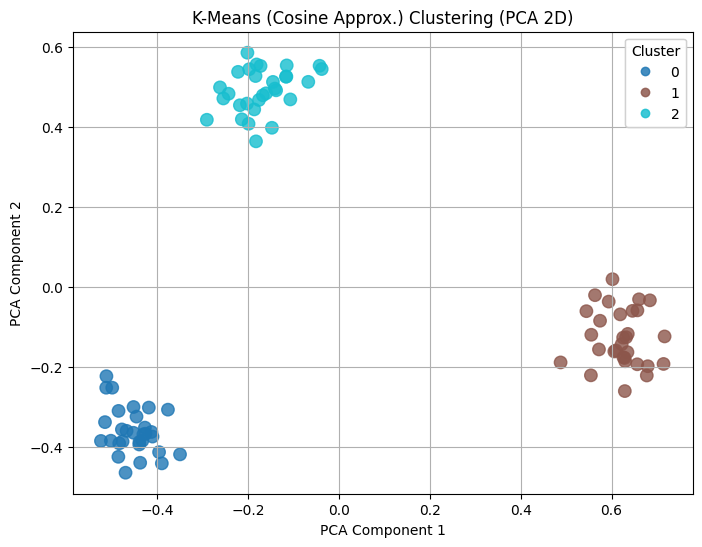

,true_label,cluster,pca_x,pca_y
0,eden,2,-0.115040,0.553641
1,eden,2,-0.147601,0.397565
2,eden,2,-0.186575,0.443531
3,eden,2,-0.183677,0.527067
4,eden,2,-0.242995,0.482801


In [ ]:
X = np.stack(df["embedding_vector"].values)
X_norm = normalize(X, norm='l2')

k = len(df["true_label"].unique())
kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster"] = kmeans.fit_predict(X_norm)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

df["pca_x"] = X_pca[:, 0]
df["pca_y"] = X_pca[:, 1]

plt.figure(figsize=(8,6))
scatter = plt.scatter(df["pca_x"], df["pca_y"], c=df["cluster"], cmap="tab10", s=80, alpha=0.8)
plt.title("K-Means (Cosine Approx.) Clustering (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
legend = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend)
plt.grid(True)
plt.show()



Silhouette Score (overall): 0.30333388786071264


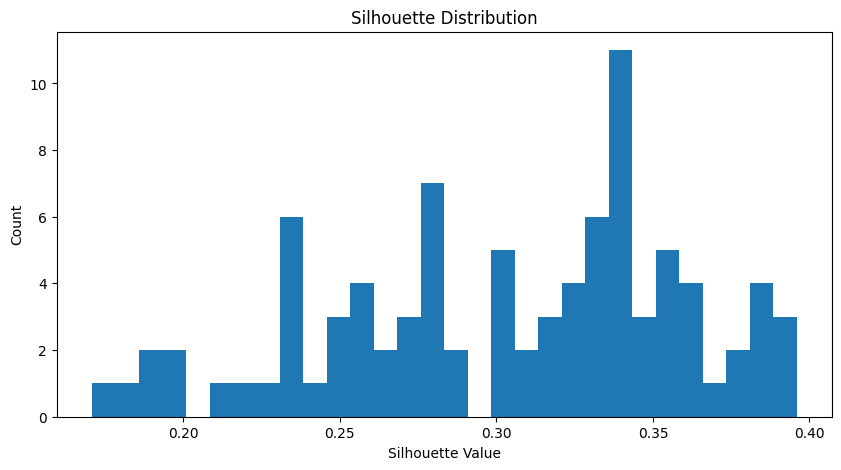

In [37]:
sil_score = silhouette_score(X_norm, df["cluster"])
sil_samples = silhouette_samples(X_norm, df["cluster"])

df["silhouette"] = sil_samples

print("Silhouette Score (overall):", sil_score)
plt.figure(figsize=(10,5))
plt.hist(df["silhouette"], bins=30)
plt.title("Silhouette Distribution")
plt.xlabel("Silhouette Value")
plt.ylabel("Count")
plt.show()